In [1]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1+cpu requires torchdata==0.6.0, but you have torchdata 0.5.1 which is incompatible.
torchvision 0.15.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Code borrow from Lab 1 of the course: Generative AI with LLM

In [7]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig
import pandas as pd
import datasets

## 1. Load dataset

In [46]:
df = pd.read_csv("/kaggle/input/chatter-sentiment-transition/df.csv")

df['sentiment'] = df['sentiment'].apply(lambda x: x.lstrip())
df['message'] = df['message'].apply(lambda x: x.lstrip())

In [47]:
df.to_csv("/kaggle/working/df.csv", index=False)

In [49]:
dataset = datasets.Dataset.from_pandas(df)
dataset

Dataset({
    features: ['conversation_id', 'message', 'sentiment', 'speaker_id'],
    num_rows: 188378
})

In [50]:
example_indices = [40, 200]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT SENTENCE:')
    print(dataset[index]['message'])
    print(dash_line)
    print('SENTIMENT:')
    print(dataset[index]['sentiment'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT SENTENCE:
I wonder if they met how that would go from there
---------------------------------------------------------------------------------------------------
SENTIMENT:
Curious to dive deeper
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Example  2
---------------------------------------------------------------------------------------------------
INPUT SENTENCE:
Yeah, and the Loch Ness monster is protected under the 1912 Scottish Animal Protection Act.
---------------------------------------------------------------------------------------------------
SENTIMENT:
Surprised
------------------------------------------------

Load the [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5), creating an instance of the `AutoModelForSeq2SeqLM` class with the `.from_pretrained()` method. 

In [11]:
model_name='google/flan-t5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

To perform encoding and decoding, you need to work with text in a tokenized form. **Tokenization** is the process of splitting texts into smaller units that can be processed by the LLM models. 

Download the tokenizer for the FLAN-T5 model using `AutoTokenizer.from_pretrained()` method. Parameter `use_fast` switches on fast tokenizer. At this stage, there is no need to go into the details of that, but you can find the tokenizer parameters in the [documentation](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/auto#transformers.AutoTokenizer).

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

Test the tokenizer encoding and decoding a simple sentence:

In [13]:
sentence = "What time is it, Tom?"

sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0], 
        skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded["input_ids"][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

ENCODED SENTENCE:
tensor([ 363,   97,   19,   34,    6, 3059,   58,    1])

DECODED SENTENCE:
What time is it, Tom?


Now it's time to explore how well the base LLM summarizes a dialogue without any prompt engineering. **Prompt engineering** is an act of a human changing the **prompt** (input) to improve the response for a given task.

As we have a multiple choice quesitons, we need to generate the options, we will use the non-char format for now. 

In [51]:
sentiment_list = df["sentiment"].unique()

In [52]:
options_prefix = "OPTIONS:\n- "
separator = "\n- "
options = options_prefix + separator.join(sentiment_list)

print(options)

OPTIONS:
- Curious to dive deeper
- Happy
- Neutral
- Surprised
- Disgusted
- Sad
- Fearful
- Angry


In [53]:
for i, index in enumerate(example_indices):
    message = dataset[index]['message']
    sentiment = dataset[index]['sentiment']
    
    prompt = f"""
Which sentiment is the following sentence?

{message}

{options}
    """
    
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE SENTIMENT:\n{sentiment}')
    print(dash_line)
    print(f'MODEL GENERATION:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Which sentiment is the following sentence?

I wonder if they met how that would go from there

OPTIONS:
- Curious to dive deeper
- Happy
- Neutral
- Surprised
- Disgusted
- Sad
- Fearful
- Angry
    
---------------------------------------------------------------------------------------------------
BASELINE SENTIMENT:
Curious to dive deeper
---------------------------------------------------------------------------------------------------
MODEL GENERATION:
Curious to dive deeper

---------------------------------------------------------------------------------------------------
Example  2
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Which sentiment is the following sentence?

Yeah, and the Loch 

## 2. apply to the dataset

In [29]:
pip install evaluate --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [54]:
import random
import evaluate

In [55]:
sent_to_idx = dict(zip(sentiment_list, range(len(sentiment_list))))

In [56]:
sent_to_idx

{'Curious to dive deeper': 0,
 'Happy': 1,
 'Neutral': 2,
 'Surprised': 3,
 'Disgusted': 4,
 'Sad': 5,
 'Fearful': 6,
 'Angry': 7}

In [82]:
test_indices = random.sample(range(188378), 10000)

In [75]:
from tqdm import tqdm

In [83]:
references = []
predictions = []
fail = []

for i, index in tqdm(enumerate(test_indices)):
    message = dataset[index]['message']
    sentiment = dataset[index]['sentiment']
    
    prompt = f"""
Which sentiment is the following sentence?

{message}

{options}
    """
    
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    if output.capitalize() in sent_to_idx: 
        references.append(sent_to_idx[sentiment])
        predictions.append(sent_to_idx[output.capitalize()])
    else:
        fail.append(index)

10000it [56:54,  2.93it/s]


In [84]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

<Axes: >

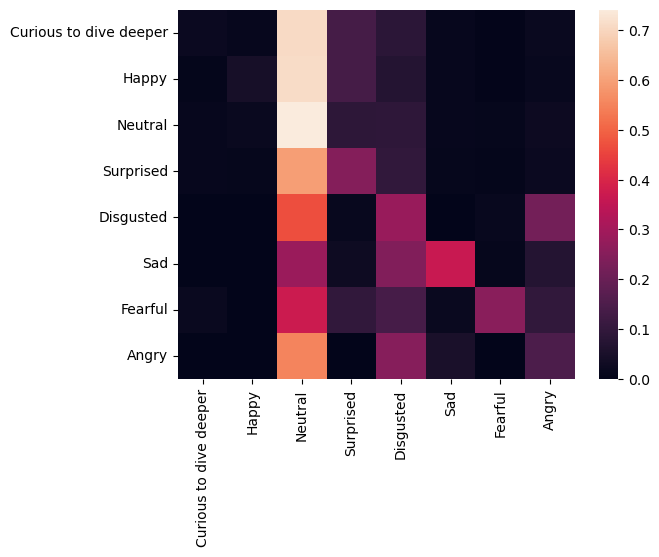

In [85]:
cm = confusion_matrix(references, predictions, normalize='true')
sns.heatmap(cm, xticklabels=sentiment_list, yticklabels=sentiment_list)

## Appendix: configuration

In [ ]:
generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')